In [1]:
using LinearAlgebra: I
using Random: MersenneTwister
using StatsBase: mean, sample, Weights

using Test: @testset, @test

In [2]:
@enum Action C D
@enum Strategy ALL_C ALL_D FRIEND HEIDER
const ActionPair = Tuple{Action, Action}

@kwdef struct Param
    N::Int = 100
    b::Float64 = 1.5
    c::Float64 = 0.5
    r::Float64 = 0.1
    μ::Float64 = 0.01
    steps_per_generation::Int = 10
    generations::Int = 4 * 10^5
    trials::Int = 10
end

mutable struct Model
    p::Param                       # Model parameters
    payoff_vec::Vector{Float64}    # Agents' payoffs
    weights::Matrix{Float64}       # Agents' relationships
    strategy_vec::Vector{Strategy} # Agents' strategies

    Model(p::Param) = new(p, fill(0.0, p.N), I(p.N), fill(ALL_D, p.N))
end

"""
関係値を算出する。(-1 ≦ 関係値 ≦ 1)
"""
function calc_relationship_score(model::Model, focal_id::Int, opponent_id::Int)::Float64
    focal_strategy = model.strategy_vec[focal_id]

    # 行ベクトル mx (関係ベクトル) は自分 (agent) と他の全エージェントとの関係を表す。
    mx = model.weights[focal_id:focal_id, :]

    # 列ベクトル nx (評判ベクトル) はゲームの相手 (opponent) が全エージェントからどう思われているかを表す。
    ny = model.weights[:, opponent_id:opponent_id]

    # if (mx * ny)[1, 1] > 2
    #     _rs = (mx * ny)[1, 1]
    #     @show _rs, sigmoid(_rs), action(_rs)
    # end

    relationship_score = if focal_strategy == HEIDER
        # ハイダーエージェント x は、エージェント y とペアになったとき、評価ベクトル ny をとり、
        # 各要素 i (エージェント i の y に対する意見) にそれぞれのエージェント i との関係を乗じ、
        # 関係スコア rs = mx × ny となる。
        (mx * ny)[1, 1]
    elseif focal_strategy == FRIEND
        # 友人とは、関係 sxi > 0 のエージェントである。
        # 友人重視型エージェントの関係ベクトルは、𝐦′𝑥 = max {0, mx} に置き換えられる。
        # 関係スコア rs = 𝐦′𝑥 × ny は、友人の意見に基づいて重み付けして集約されたものである。
        # つまり、友人じゃないエージェントの意見は無視する。
        ((mx .* (mx .> 0)) * ny)[1, 1]
    elseif focal_strategy == ALL_C
        1.0
    elseif focal_strategy == ALL_D
        -1.0
    else
        error("Invalid strategy: $(focal_strategy).")
    end

    return relationship_score
end

sigmoid(rs::Float64)::Float64 = 1 / (1 + exp(-rs / 0.2))

@testset "sigmoid" begin
    @test sigmoid(-1.0) < 0.01
    @test sigmoid(-0.5) == 0.07585818002124355
    @test sigmoid(-0.1) == 0.3775406687981454
    @test sigmoid(0.0) == 0.5
    @test sigmoid(0.1) == 0.6224593312018546
    @test sigmoid(0.5) == 0.9241418199787566
    @test sigmoid(1.0) > 0.99
end

action(rs::Float64)::Action = sigmoid(rs) > rand() ? C : D

function get_action_pair(model::Model, focal_id::Int, opponent_id::Int)::ActionPair
    focal_action = calc_relationship_score(model, focal_id, opponent_id) |> action
    opponent_action = calc_relationship_score(model, opponent_id, focal_id) |> action

    return (focal_action, opponent_action)
end

function update_payoffs!(model::Model, focal_id::Int, opponent_id::Int, action_pair::ActionPair)::Nothing
    if action_pair == (C, C)
        model.payoff_vec[focal_id] += (model.p.b - model.p.c)
        model.payoff_vec[opponent_id] += (model.p.b - model.p.c)
    elseif action_pair == (C, D)
        model.payoff_vec[focal_id] -= model.p.c
        model.payoff_vec[opponent_id] += model.p.b
    elseif action_pair == (D, C)
        model.payoff_vec[focal_id] += model.p.b
        model.payoff_vec[opponent_id] -= model.p.c
    end

    return
end

function update_weights!(model::Model, focal_id::Int, opponent_id::Int, action_pair::ActionPair)::Nothing
    if action_pair == (C, C)
        model.weights[focal_id, opponent_id] += model.p.r
        model.weights[opponent_id, focal_id] += model.p.r
    elseif action_pair == (C, D)
        model.weights[focal_id, opponent_id] -= model.p.r
        model.weights[opponent_id, focal_id] += model.p.r
    elseif action_pair == (D, C)
        model.weights[focal_id, opponent_id] += model.p.r
        model.weights[opponent_id, focal_id] -= model.p.r
    end

    model.weights[focal_id, opponent_id] = clamp(model.weights[focal_id, opponent_id], -1, 1)
    model.weights[opponent_id, focal_id] = clamp(model.weights[opponent_id, focal_id], -1, 1)

    return
end

function run_one_step!(model::Model)::Nothing
    for focal_id in 1:model.p.N
        # ランダムに一人の相手を選ぶ
        # opponent_id = rand(filter(!=(focal_id), 1:model.p.N))
        
        # 繋がりの強い相手を選ぶ
        candidate_id_vec = filter(!=(focal_id), 1:model.p.N)
        relationship_vec = sigmoid.(model.weights[focal_id, candidate_id_vec])
        opponent_id = sample(candidate_id_vec, Weights(relationship_vec))
        
        action_pair = get_action_pair(model, focal_id, opponent_id)
        update_payoffs!(model, focal_id, opponent_id, action_pair)
        update_weights!(model, focal_id, opponent_id, action_pair)
    end
end

population_per_strategy(model::Model)::Dict{Strategy, Int} = Dict(strategy => count(==(strategy), model.strategy_vec) for strategy in instances(Strategy))

function fitness_per_strategy(model::Model)::Dict{Strategy, Float64}
    payoff_dict = Dict(strategy => mean([model.payoff_vec[i] for i in 1:model.p.N if model.strategy_vec[i] == strategy]) for strategy in instances(Strategy))

    for (key, value) in payoff_dict
        if isnan(value)
            payoff_dict[key] = 0.0
        end
    end

    payoff_sum = sum(values(payoff_dict))

    return Dict(key => value / payoff_sum for (key, value) in payoff_dict)
end

function adaptation!(model::Model)::Nothing
    # ランダムに一人のエージェントを選択する (ToDo: 適応度の低い人を選ぶべき)
    focal_id = rand(1:model.p.N)
    
    
    
    fitness_dict = fitness_per_strategy(model)
    strategy_vec = collect(keys(fitness_dict))
    fitness_vec = collect(values(fitness_dict))

    model.strategy_vec[focal_id] = model.p.μ > rand() ? rand(strategy_vec) : sample(strategy_vec, Weights(fitness_vec))

    return
end

function run_one_generation!(model::Model)::Nothing
    model.payoff_vec .= 0.0

    for step in 1:model.p.steps_per_generation
        run_one_step!(model)
    end

    adaptation!(model)
end

function run!(p::Param)::Tuple{Array{Int, 3}, Matrix{Matrix{Float64}}, Matrix{Vector{Strategy}}}
    @assert p.generations % 100 == 0
    
    strategy_count = length(instances(Strategy))
    population_log = fill(0, p.trials, p.generations, strategy_count)
    weights_log = fill(fill(0.0, 2, 2), p.trials, Int(p.generations / 100))
    strategy_vec_log = fill(fill(ALL_D, p.N), p.trials, Int(p.generations / 100))

    for trial in 1:p.trials
        model = Model(p)

        for generation in 1:p.generations
            run_one_generation!(model)
            
            population_dict = population_per_strategy(model)
            for (strategy_num, strategy) in enumerate(instances(Strategy))
                population_log[trial, generation, strategy_num] = population_dict[strategy]
            end

            if generation % 100 == 0
                weights_log[trial, Int(generation / 100)] = model.weights
                strategy_vec_log[trial, Int(generation / 100)] = model.strategy_vec
            end
        end
    end
    
    return population_log, weights_log, strategy_vec_log
end;

Test Summary: | Pass  Total  Time
sigmoid       |    7      7  0.1s


In [3]:
using Graphs
using GraphPlot
using Colors

function strategy_to_color(strategy::Strategy)::RGB
    return if strategy == ALL_C
        colorant"blue"
    elseif strategy == ALL_D
        colorant"red"
    elseif strategy == FRIEND
        colorant"white"
    elseif strategy == HEIDER
        colorant"gray"
    else
        error("Invalid strategy: $(strategy).")
    end
end

function show_network(population_vec::Vector{Int}, weights::BitMatrix, strategy_vec::Vector{Strategy})::Nothing
    g = SimpleGraph(weights)
    N = nv(g)
    color_vec = [strategy_to_color(strategy) for strategy in strategy_vec]
    gplot(g, nodefillc = color_vec) |> display

    println("N:\t$(N)")
    for (key, value) in zip(instances(Strategy), population_vec)
        println("$(key):\t$(value)\t($(value / N))")
    end

    components = connected_components(g)
    components = sort(components, by = length, rev = true)

    println("Component count: $(length(components))")
    println([length(component) for component in components])
end;

In [4]:
N = 10^2
generations = 10^5
trials = 3

param = Param(N = N, generations = generations, trials = trials)
@time population_log, weights_log, strategy_vec_log = run!(param);

379.230145 seconds (3.22 G allocations: 2.125 TiB, 1.88% gc time)


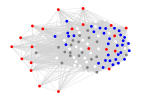

N:	100
ALL_C:	33	(0.33)
ALL_D:	21	(0.21)
FRIEND:	26	(0.26)
HEIDER:	20	(0.2)
Component count: 1
[100]


In [5]:
trial = 3
generation = 10^5

population_vec = population_log[trial, generation, :]
weights = weights_log[trial, Int(generation / 100)] .> 0
weights = weights .* transpose(weights) # 両思いの場合だけ1になるようにする
strategy_vec = strategy_vec_log[trial, Int(generation / 100)]

show_network(population_vec, weights, strategy_vec)

In [6]:
trial = 2
generation = 2000
weights_log[trial, Int(generation / 100)]

100×100 Matrix{Float64}:
  1.0   1.0          0.5  -0.7  1.0  1.0  …  1.0  1.0  1.0  -0.5          1.0
  0.8   1.0          0.5   0.1  0.9  1.0     0.8  0.9  1.0  -0.5          1.0
  1.0   0.5          1.0  -0.5  1.0  1.0     1.0  1.0  1.0  -0.5          1.0
  1.0   0.8          0.9   1.0  0.6  0.6     0.5  0.8  0.5  -0.7          1.0
  1.0  -0.7          0.6  -0.6  1.0  1.0     1.0  1.0  1.0  -0.6          1.0
  1.0   0.9          0.5   0.4  1.0  1.0  …  1.0  1.0  1.0   0.6          1.0
  1.0  -0.6          0.8  -0.2  1.0  1.0     1.0  1.0  1.0  -0.3          1.0
  1.0  -0.7          0.7  -0.4  1.0  1.0     1.0  1.0  1.0  -0.4          1.0
  1.0  -0.3          0.7  -0.8  1.0  1.0     1.0  1.0  1.0  -0.2          1.0
 -0.3   0.8          1.0   0.3  0.7  0.9     0.8  0.9  0.9   1.0          1.0
  1.0   0.4          1.0  -0.5  1.0  1.0  …  0.9  1.0  1.0  -1.0          1.0
  0.9   0.9          0.8   1.0  0.8  0.9     0.8  0.8  1.0   0.2          1.0
  1.0   1.38778e-16  1.0   0.4  1.0  1.